In [57]:
import jax 
import jax.numpy as jnp

import matplotlib.pyplot as plt
import seaborn as sns

from scoresbibm.tasks import HHTask
from scoresbibm.utils import load_model,query
from scoresbibm.utils.plot import use_style

from sbi.analysis import pairplot, marginal_plot
import numpy as np


import logging
logging.getLogger('matplotlib.font_manager').disabled = True

In [357]:
PATH = "../../results/bm_hh"

In [358]:
df = query(PATH, method_sde_name="vesde")

/mnt/qb/work/macke/mgloeckler90/simformer/src/scoresbibm/scoresbibm/utils/data_utils.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_q["value"] = df_q["value"].apply(lambda x: np.array(eval(x)) if isinstance(x, str) else np.array(x))
/mnt/qb/work/macke/mgloeckler90/simformer/src/scoresbibm/scoresbibm/utils/data_utils.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_q["value"] = df_q["value"].apply(lambda x: np.mean(x) if x is not None else None)


In [359]:
df

,method,task,num_simulations,seed,model_id,metric,value,time_train,time_eval,cfg
0,score_transformer,hh,100000,0,0,c2st_joint,0.762807,1776.105743,11.643386,"{'name': 'bm_hh2', 'seed': 0, 'model_id': None..."


In [360]:
limits = ((1.,2.), (60,120), (10,30), (0.1,0.5), (40,70),(-100, -60),(-90,-60))
labels = [r"$C_m$", r"$g_{Na}$", r"$g_K$", r"$g_L$", r"$E_{Na}$", r"$E_K$", r"$E_L$"]

In [361]:
task = HHTask()

simulator = task.get_simulator()
dataset = task.get_data(100, rng=jax.random.PRNGKey(0))

In [362]:
x_o = dataset["x"][1,:7]
energy_true = dataset["x"][1,7:]
theta_true = dataset["theta"][1]

In [363]:
def convert_charge_to_energy(E):
    E = E # Energy is negative
    E = jnp.diff(E) # Non cumulative energy
    E = jnp.convolve(E, 1/5*jnp.ones(5), mode="same") # Smooth due to numerical differentiation error
    return convert_total_energy(E)

def convert_total_energy(E):
    E = -E # Energy is negative
    E = E/1000 # mS to S
    E = E / 1000 # mV to V
    E = E * 0.628e-3 # Area of the membrane
    e = 1.602176634e-19 # Elementary charge
    N_Na = E / e # Number of elementary charges
    valence_Na = 1 # Valence of sodium
    number_of_transports = 3 # Number of Na out per ATP 
    ATP_Na = N_Na / (valence_Na * number_of_transports) # Number of ATP
    ATP_energy = 10e-19 # Energy by ATP hydrolysis
    E = ATP_Na * ATP_energy # Energy in Joules
    E = E / 0.2 # Energy in J/s
    return E * 1e+6 # Energy in uJ/s

In [364]:
convert_total_energy(energy_true)

Array([19.953], dtype=float32)

In [365]:
V, energy, _ = simulator(jax.random.PRNGKey(0),theta_true)

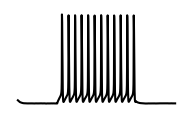

In [366]:
with use_style("pyloric"):
    fig = plt.figure(figsize=(2,1.25))
    plt.plot(V, color="black")
    plt.axis("off")
    plt.tight_layout()
    plt.show()
    fig.savefig("true_trace.svg")

In [367]:
convert_charge_to_energy(energy).max()

Array(0.119, dtype=float32)

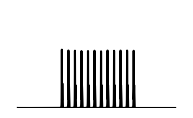

In [368]:
with use_style("pyloric"):
    fig = plt.figure(figsize=(2,1.25))
    plt.plot(convert_charge_to_energy(energy), color="black")
    plt.ylim(0.,0.2)
    plt.axis("off")
    plt.tight_layout()
    plt.show()
    fig.savefig("true_energy.svg")

In [405]:
model = load_model(PATH, df["model_id"].iloc[0])

In [406]:
samples_only_spike_count = model.sample(10000, x_o = x_o[:1], condition_mask=jnp.array([False]*7 +[True] + [False]*6 + [False]), rng=jax.random.PRNGKey(0))

In [407]:
samples_only_spike_count_and_resting_stats = model.sample(10000, x_o = x_o[:3], condition_mask=jnp.array([False]*7 +[True]*3 + [False]*4 + [False]), rng=jax.random.PRNGKey(0))

In [408]:
samples_all_stats = model.sample(10000, x_o = x_o, condition_mask=jnp.array([False]*7 +[True]*7 + [False]), rng=jax.random.PRNGKey(42))

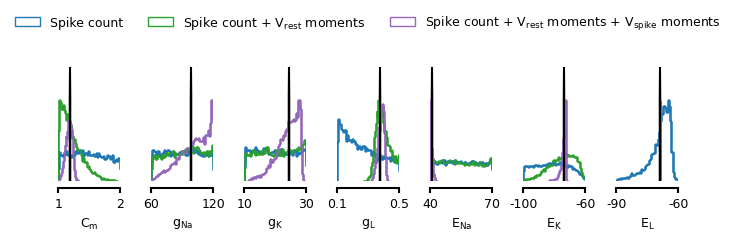

In [441]:
with use_style("pyloric"):
    fig, axes = marginal_plot([np.array(samples_only_spike_count[:, :7]),np.array(samples_only_spike_count_and_resting_stats[:, :7]), np.array(samples_all_stats[:, :7])], points= np.array([theta_true]), limits=limits,figsize=(8,1.5), labels=labels, bins=50, alpha=0.5, points_colors=["black"])
    # Incrase space between subplots
    plt.subplots_adjust(wspace=0.5)
    for i in range(7):
        axes[0,i].set_xticks(limits[i])

    plt.legend(["Spike count", "Spike count + $V_{rest}$ moments", "Spike count + $V_{rest}$ moments + $V_{spike}$ moments "], ncols=3, loc = "upper center", bbox_to_anchor=(-4., 1.5), frameon=False)
    plt.show()
    fig.savefig("bm_hh_marginal.svg", bbox_inches="tight")

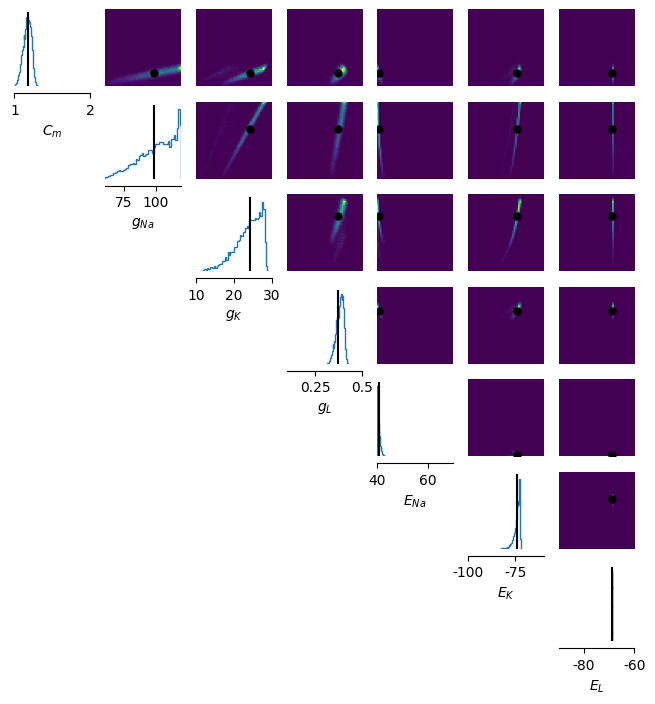

In [410]:
_ =pairplot(np.array(samples_all_stats[:, :7]), points= np.array([theta_true]), limits=limits,figsize=(8,8), labels=labels, bins=50, alpha=0.5, points_colors=["black"])
plt.show()

/tmp/ipykernel_1870566/1739192374.py:8: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


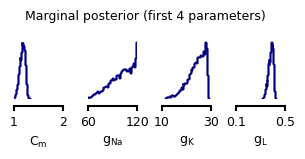

In [411]:
with use_style("pyloric"):
    fig, axes = marginal_plot([np.array(samples_all_stats[:, :4])], limits=limits,figsize=(3.5,0.75), labels=labels, bins=50, alpha=0.5, samples_colors=["navy"], points_colors=["black"])
    plt.subplots_adjust(wspace=0.5)
    for i in range(4):
        axes[0,i].set_xticks(limits[i])
    fig.suptitle("Marginal posterior (first 4 parameters)", y=1.3)
    
    plt.tight_layout()
    plt.show()
    fig.savefig("bm_hh_marginal_all_features.svg", bbox_inches="tight")

In [412]:
with jax.default_device(jax.devices("cpu")[0]):
    simulator_energies = []
    for i in range(10):
        _,energies,stats = jax.vmap(simulator)(jax.random.split(jax.random.PRNGKey(1), 1000), samples_all_stats[i*1000:(i+1)*1000, :7])
        simulator_energies.append(energies)
        
    simulator_energies = jnp.concatenate(simulator_energies, axis=0)

In [413]:
Vs, _,summary = jax.vmap(simulator)(jax.random.split(jax.random.PRNGKey(42), 3), samples_all_stats[3:6, :7])

In [414]:
#Vs, _,summary = jax.vmap(simulator, in_axes=(0, None))(jax.random.split(jax.random.PRNGKey(0), 100), theta_true)

In [415]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib import colors

darkgrey_rgb = colors.to_rgb('darkgrey')
grey_rgb = colors.to_rgb('grey')
lightgrey_rgb = colors.to_rgb('lightgrey')

In [416]:
model.sde_init_params.keys()

dict_keys(['data', 'name', 'sigma_max', 'sigma_min', 'T_max', 'T_min'])

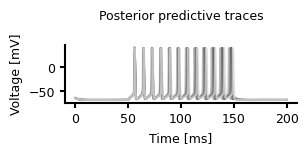

In [417]:
with use_style("pyloric"):
    fig = plt.figure(figsize=(3,0.75))
    ts = jnp.linspace(0, 200, 5000)
    plt.plot(ts,V, color="black")
    plt.plot(ts,Vs[0,:], color="darkgrey", alpha=0.8)
    plt.plot(ts,Vs[1,:], color="grey", alpha=0.8)
    plt.plot(ts,Vs[2,:], color="lightgrey", alpha=0.8)
    plt.xlabel("Time [ms]")
    plt.ylabel("Voltage [mV]")
    plt.title("Posterior predictive traces",y=1.3)
    fig.savefig("bm_hh_traces.svg", bbox_inches="tight")
    
    plt.show()

In [418]:
predicted_energies = convert_total_energy(samples_all_stats[:, -1:])
sim_energies = convert_total_energy(simulator_energies[:,-1:])

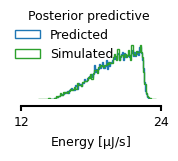

In [419]:
with use_style("pyloric"):
    fig, axes = marginal_plot([np.array(predicted_energies), np.array(sim_energies)], points= np.array(energy_true),figsize=(1.8,0.75),labels=[r"Energy [$\mu$J/s]"],  alpha=0.5, points_colors=["black"],hist_diag={"bins":100, "density":True})
    axes[0,0].set_xlim([12, 24])
    axes[0,0].set_xticks([12,24])    

    fig.suptitle("Posterior predictive", y=1.3)
    fig.legend(["Predicted", "Simulated"], frameon=False,bbox_to_anchor=(0.7, 1.2), ncol=1) 
    #plt.tight_layout()
    fig.savefig("bm_hh_marginal_energy_all_features.svg", bbox_inches="tight")
    plt.show()

In [420]:
jnp.quantile(simulator_energies[:,-1:], 0.1), jnp.quantile(simulator_energies[:,-1:], 0.9)

(Array(-3393.681, dtype=float32), Array(-2668.263, dtype=float32))

In [421]:
condition_mask = jnp.array([False]*7 +[True]*7 + [False])
constraint_mask = jnp.array([False]*7 +[False]*7 + [True])

In [422]:
constraint_lower = model.z_score_params["z_score_fn"](  jnp.array([-2660.]),jnp.array([14], dtype=int))
constraint_upper = model.z_score_params["z_score_fn"]( jnp.array([0.]),jnp.array([14], dtype=int))

In [423]:
# plt.plot(jnp.linspace(0, 1, 100), exp_power_scaling(jnp.linspace(0, 1, 100), scaling=5, max_steepness=100, order=4))
# plt.show()

In [424]:

samples = model.sample(10000, x_o=x_o, condition_mask=condition_mask, rng=jax.random.PRNGKey(0),sampling_method="generalized_guidance",num_steps=200, resampling_steps=25, constraint_name="interval", constraint_mask=constraint_mask, constraint_kwargs={"a":constraint_lower, "b":None},return_conditioned_samples=False)

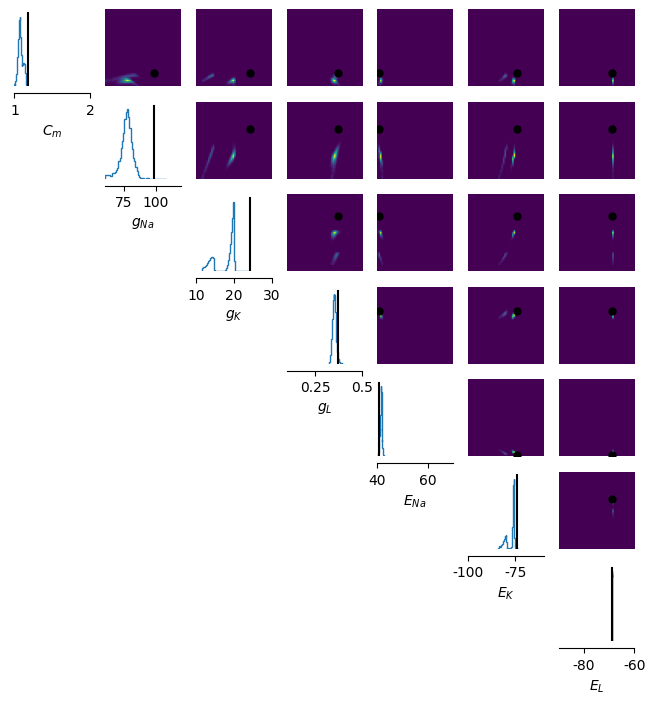

In [425]:
_ =pairplot(np.array(samples[:, :7]), points= np.array([theta_true]), limits=limits,figsize=(8,8), labels=labels, bins=50, alpha=0.5, points_colors=["black"])
plt.show()

In [426]:
with jax.default_device(jax.devices("cpu")[0]):
    simulator_energies_constrained = []
    for i in range(10):
        _,energies,stats = jax.vmap(simulator)(jax.random.split(jax.random.PRNGKey(i), 1000), samples[i*1000:(i+1)*1000, :7])
        simulator_energies_constrained.append(energies)
        
    simulator_energies_constrained = jnp.concatenate(simulator_energies_constrained, axis=0)

/tmp/ipykernel_1870566/3404225447.py:8: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


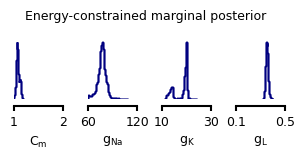

In [427]:
with use_style("pyloric"):
    fig, axes = marginal_plot([np.array(samples[:, :4])], limits=limits,figsize=(3.5,0.75), labels=labels, bins=50, alpha=0.5,samples_colors=["navy"], points_colors=["black"], color="C2")
    plt.subplots_adjust(wspace=0.5)
    for i in range(4):
        axes[0,i].set_xticks(limits[i])

    fig.suptitle("Energy-constrained marginal posterior", y=1.3)
    plt.tight_layout()
    plt.show()
    fig.savefig("bm_hh_marginal_energies_constrained.svg", bbox_inches="tight")

In [428]:
converted_boundary = convert_total_energy( jnp.array([-2660.0]))

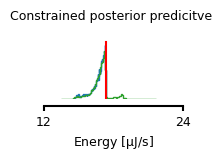

In [429]:
with use_style("pyloric"):
    fig, axes = marginal_plot([np.array(convert_total_energy(samples[:, -1:])), np.array(convert_total_energy(simulator_energies_constrained[:,-1:]))], points= [np.array(converted_boundary)],figsize=(1.8,0.75), bins=100,labels=[r"Energy [$\mu$J/s]"], alpha=0.5, points_colors=["red", "black"],  hist_diag={"bins":100, "density":True})
    axes[0,0].set_xlim([12, 24])
    axes[0,0].set_xticks([12,24])    
    fig.suptitle("Constrained posterior predicitve", y=1.3)
    #plt.tight_layout()
    fig.savefig("bm_hh_marginal_energy_constraint.svg", bbox_inches="tight")
    plt.show()

In [430]:
Vs, _,summary = jax.vmap(simulator)(jax.random.split(jax.random.PRNGKey(43), 3), samples[:3, :7])

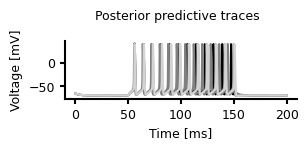

In [431]:
with use_style("pyloric"):
    fig = plt.figure(figsize=(3,0.75))
    ts = jnp.linspace(0, 200, 5000)
    plt.plot(ts, V, color="black")
    plt.plot(ts,Vs[0,:], color="darkgrey")
    plt.plot(ts,Vs[1,:], color="grey")
    plt.plot(ts,Vs[2,:], color="lightgrey")
    plt.xlabel("Time [ms]")
    plt.ylabel("Voltage [mV]")
    fig.suptitle("Posterior predictive traces", y=1.3)
    fig.savefig("bm_hh_traces_energy_constrained.svg", bbox_inches="tight")
    
    plt.show()

In [432]:
joint_samples = model.sample(10000, x_o=jnp.array([]), condition_mask=jnp.zeros((15,), dtype=bool), rng=jax.random.PRNGKey(0))

In [433]:
def scaling_fn(t):
    t = jnp.atleast_1d(t)
    std = model.sde.marginal_stddev(t, jnp.array([1.]))
    return (1/(std**2)) 

def constraint_fn(x,t):
    scale = scaling_fn(t)
    current_spike_count_estimate = x[7]
    current_spike_count_estimate = model.z_score_params["un_z_score_fn"](current_spike_count_estimate, model.node_id[7][None])
    current_energy_estimate = x[-1]
    current_energy_estimate = model.z_score_params["un_z_score_fn"](current_energy_estimate, model.node_id[-1][None])
    energy = convert_total_energy(current_energy_estimate)
    # Energy per spike must be smaller than 2. uJ
    constraint = jax.nn.log_sigmoid(scale* (2.- jax.nn.relu(energy)/(1e-3 + jax.nn.relu(current_spike_count_estimate))))
    return jnp.sum(constraint)

In [435]:

energy_per_spike_constrained = model.sample(10000, x_o=jnp.array([]), condition_mask=jnp.zeros((15,),dtype=bool), rng=jax.random.PRNGKey(0),sampling_method="generalized_guidance",constraint_name=None,num_steps=200, resampling_steps=25, constraint_fn=constraint_fn,return_conditioned_samples=False)

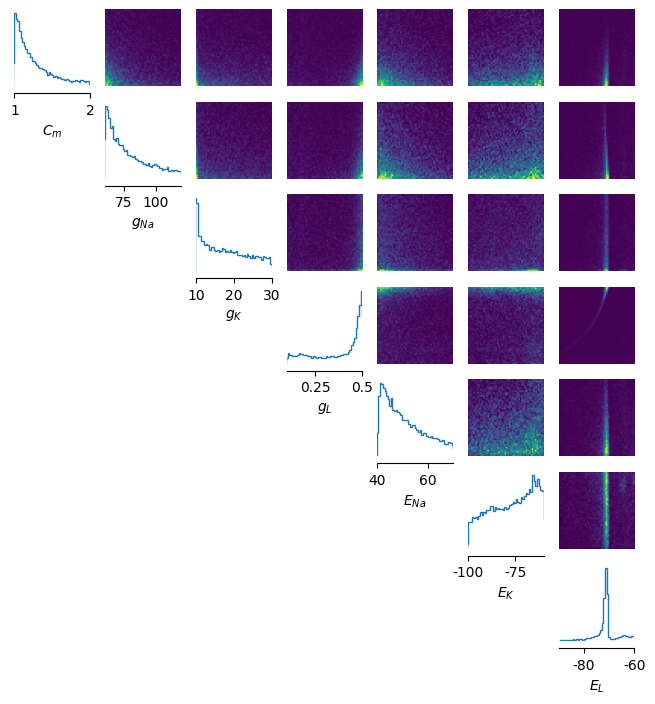

In [436]:
pairplot(np.array(energy_per_spike_constrained[:,:7]), limits=limits,figsize=(8,8), labels=labels, bins=50, alpha=0.5, points_colors=["black"])
plt.show()

In [437]:
with jax.default_device(jax.devices("cpu")[0]):
    Vs, e,summary = jax.vmap(simulator)(jax.random.split(jax.random.PRNGKey(43), 10000), energy_per_spike_constrained[:10000, :7])

In [438]:
spikes = summary[:, 0]
energy = convert_total_energy(e[:, -1:])

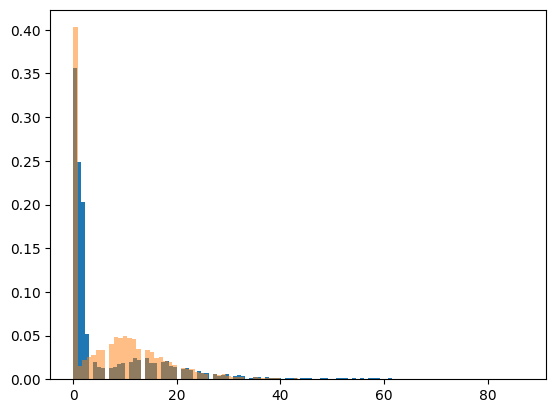

In [439]:
# Similar spike variaty
plt.hist(spikes.flatten(), bins=100, density=True)
plt.hist(jnp.round(joint_samples[:,7].flatten()),alpha=0.5, bins=100, density=True)
plt.show()

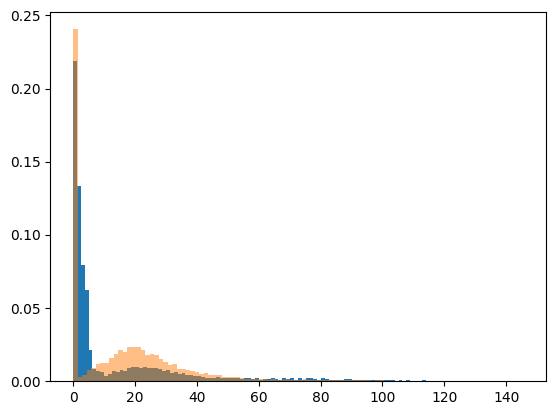

In [440]:
# Less energy
plt.hist(energy.flatten(), bins=100, density=True)
plt.hist(convert_total_energy(joint_samples[:, -1]).flatten(),alpha=0.5, bins=100, density=True)
plt.show()

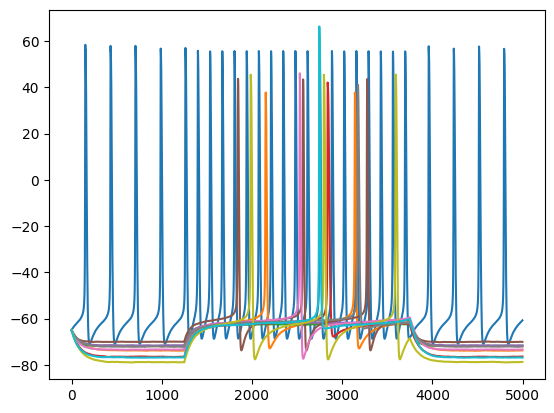

In [442]:
plt.plot(Vs[:10].T)
plt.show()